In [1]:
import NBHD
import dataset_utils
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import openpyxl

from pytorch_metric_learning import distances, losses, miners, reducers

def get_Cosine_margin(model, x_test, y_test=None):
    def cosine_distance(a, b):
        return 1 - torch.cosine_similarity(a[:, np.newaxis, :], b, dim=-1)
    
    # Compute test samples' Hamming distance
    class_hvs = model.class_hvs.data
    test_enc_hvs = model.encoding(x_test)
    test_Cosine_dist = cosine_distance(test_enc_hvs, class_hvs)

    sorted_test_Cosine_distance, _ = torch.sort(test_Cosine_dist, dim=-1, descending=False)
    test_enc_hvs_Cosine_margin = (sorted_test_Cosine_distance[:,1:]-sorted_test_Cosine_distance[:,0].unsqueeze(dim=1)).mean(dim=1).cuda()
    mean_test_Cosine_margin = torch.mean(test_enc_hvs_Cosine_margin).item()

    return mean_test_Cosine_margin


def HD_test(model, x_test, y_test):
    out = model(x_test, embedding=False)
    preds = torch.argmax(out, dim=-1)

    acc = torch.mean((preds==y_test).float())	
    return acc


def test_combination(dataset_info, dim, levels, combinations, test_epochs = 10, HD_lr = 1.0, quant_lr=1.0, t=0.7, metric_lr = 0.001, enc_type='RP', similarity_type = "cosine", device = "cuda"):
    accuracies = []
    margins = []

    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader = dataset_info

    model = NBHD.HDC(dim = nFeatures, D=dim, num_classes=nClasses,levels=levels, enc_type=enc_type, similarity_type= similarity_type)
    model.init_quantize(x_train)

    initialized = False

    for combination in combinations:
        if combination == "HD":
            if not initialized:
                model.init_class(x_train, y_train)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))
                initialized = True

            for epoch_i in range(1, test_epochs+1):
                model.HD_train_step(x_train, y_train, lr=HD_lr)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))


        elif combination == "Metric":
            optimizer = optim.Adam(model.parameters(), lr=metric_lr)
            distance = distances.CosineSimilarity()

            reducer = reducers.ThresholdReducer(low=0.0)
            loss_func = losses.TripletMarginLoss(margin=0.28, distance=distance, reducer=reducer)
            mining_func = miners.TripletMarginMiner(
                margin=0.2, distance=distance, type_of_triplets="semihard", )

            ### pytorch-metric-learning stuff ###
            for epoch_i in range(1, test_epochs + 1):
                NBHD.metric_train(model, loss_func, mining_func, device, train_loader, optimizer, epoch_i)
                if initialized:
                    accuracies.append(HD_test(model, x_test, y_test).item())
                    margins.append(get_Cosine_margin(model, x_test, y_test))
        
        
        elif combination == "Quant":
            if not initialized:
                model.init_class(x_train, y_train)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))
                initialized = True

            optimizer = optim.SGD(model.parameters() , quant_lr)

            def cosineLoss(embeddings, labels, t=t):
                similarities = model.similarity(model.class_hvs, embeddings)
                a = (1 - similarities[torch.arange(similarities.size(0)), labels]).abs().mean() #

                similarities[torch.arange(similarities.size(0)), labels] = 0
                b = similarities.abs().mean() 
                return t * a + (1-t) * b

            quant_loss = cosineLoss
            for epoch_i in range(1, test_epochs + 1):
                NBHD.quant_train(model, quant_loss, device, train_loader, optimizer, epoch_i)
                accuracies.append(HD_test(model, x_test, y_test).item())
                margins.append(get_Cosine_margin(model, x_test, y_test))

    
    if not initialized:
        model.init_class(x_train, y_train)
        accuracies.append(HD_test(model, x_test, y_test).item())
        margins.append(get_Cosine_margin(model, x_test, y_test))
        initialized = True

    plt.plot(accuracies, label="Accuracy", c = "blue")
    plt.plot(margins, label="Margins", c="cyan")
    plt.xlabel("iterations")
    plt.axvline(x=10, c= "red" , ls="--")
    plt.title("Accuracy of {} Levels, {} Dimensions, Dataset:{}, Combination: {}".format(levels, dim, dataset, combinations))
    plt.legend()
    plt.show()

    return accuracies, margins

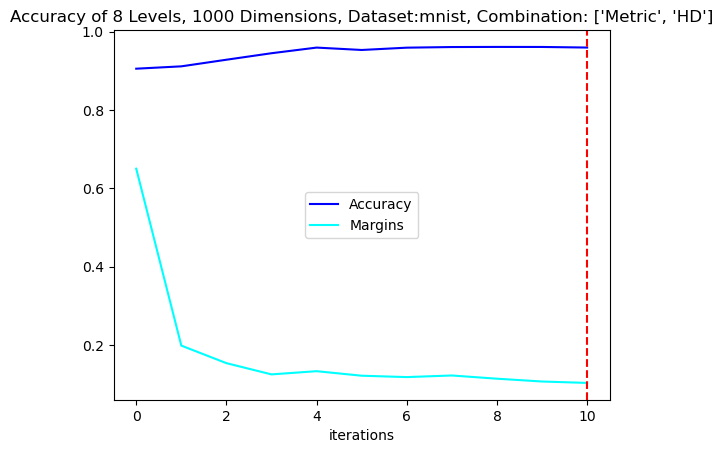

Final Acc: 0.9595999717712402  Final Margin: 0.10304759442806244


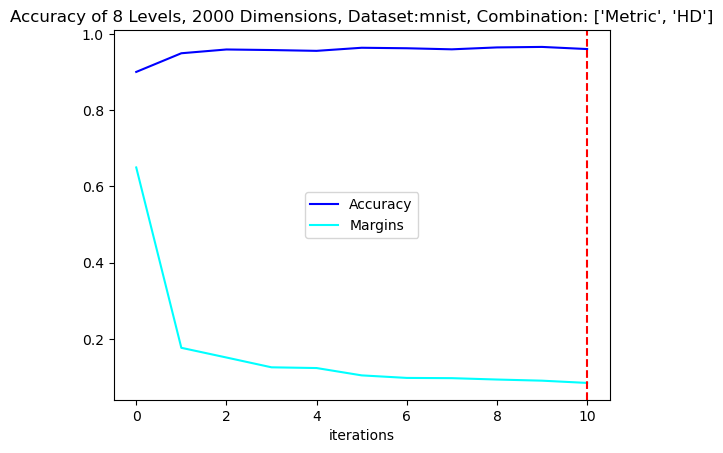

Final Acc: 0.960099995136261  Final Margin: 0.08516150712966919


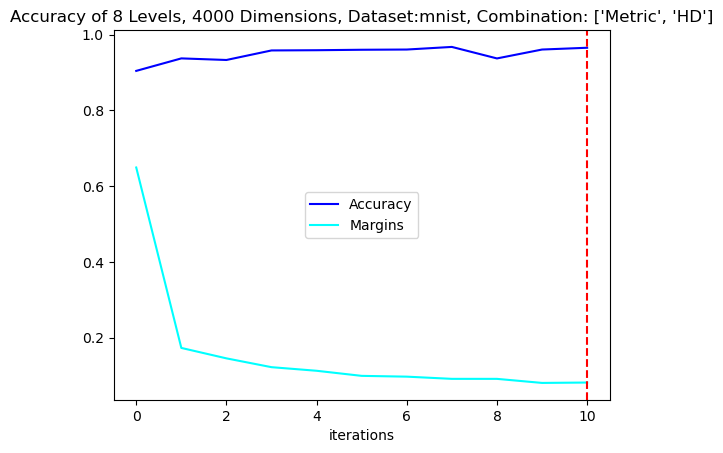

Final Acc: 0.9656999707221985  Final Margin: 0.08140850812196732


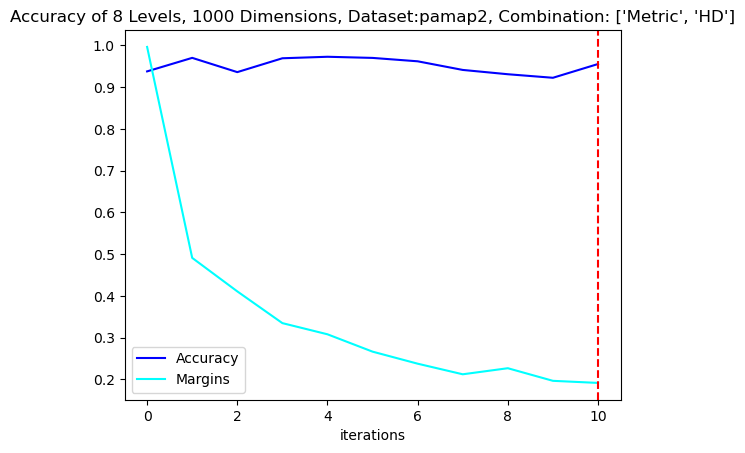

Final Acc: 0.95550537109375  Final Margin: 0.19138532876968384


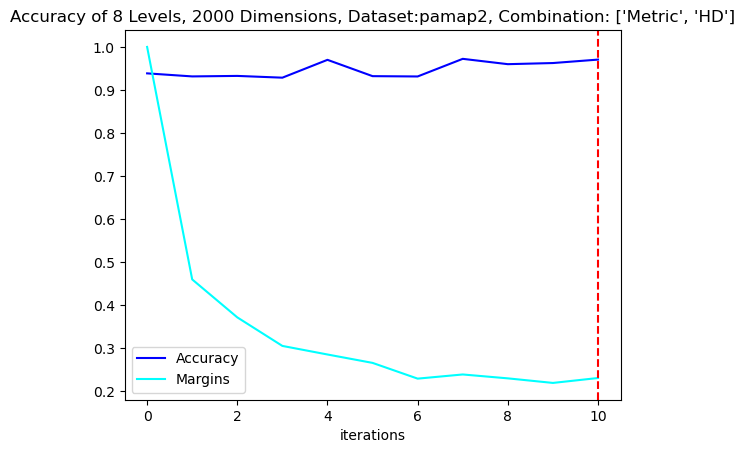

Final Acc: 0.9705810546875  Final Margin: 0.2307491898536682


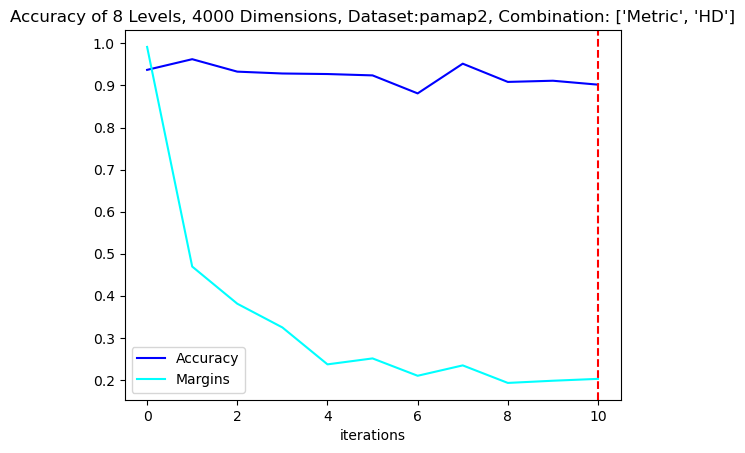

Final Acc: 0.90185546875  Final Margin: 0.20246148109436035


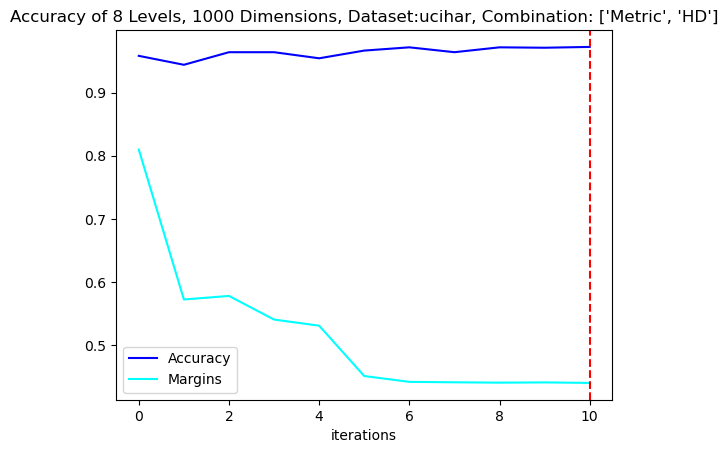

Final Acc: 0.9723294973373413  Final Margin: 0.439944863319397


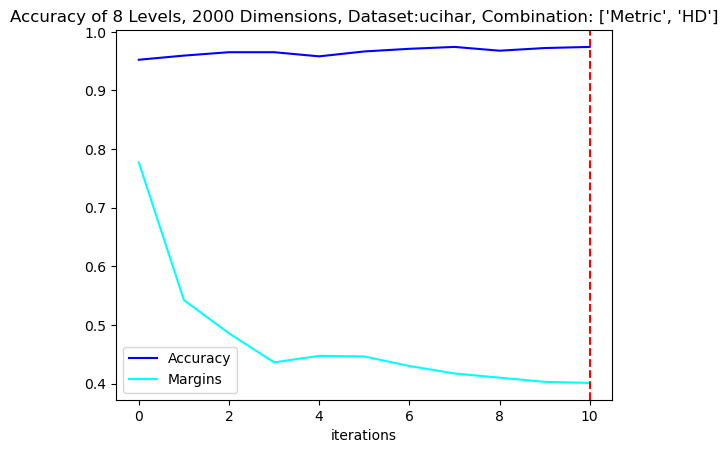

Final Acc: 0.9742599725723267  Final Margin: 0.4012193977832794


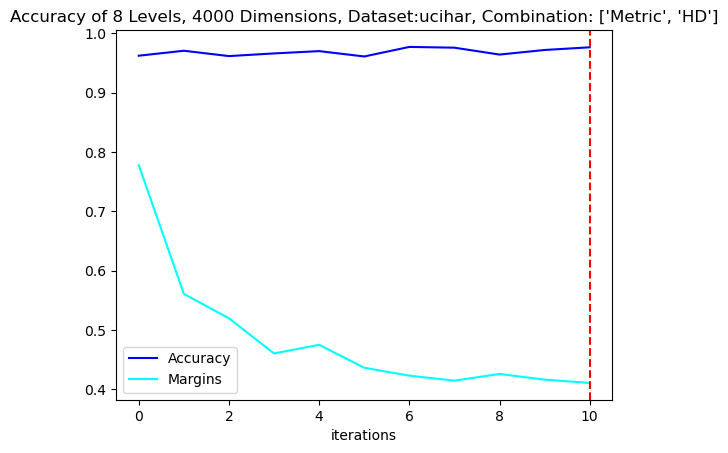

Final Acc: 0.9761905074119568  Final Margin: 0.41091278195381165


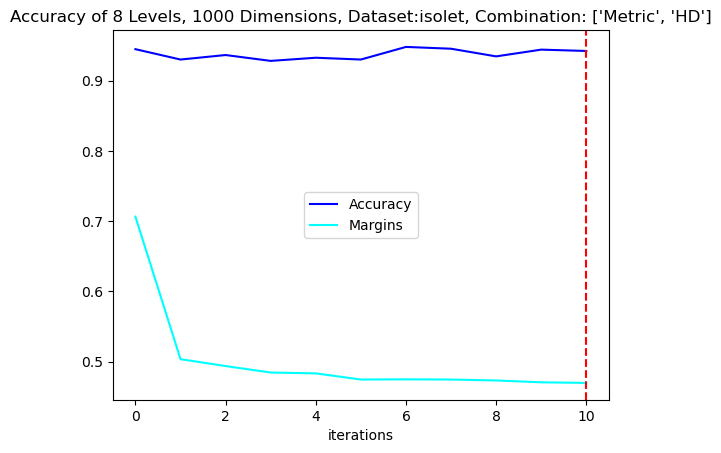

Final Acc: 0.9422706961631775  Final Margin: 0.46978363394737244


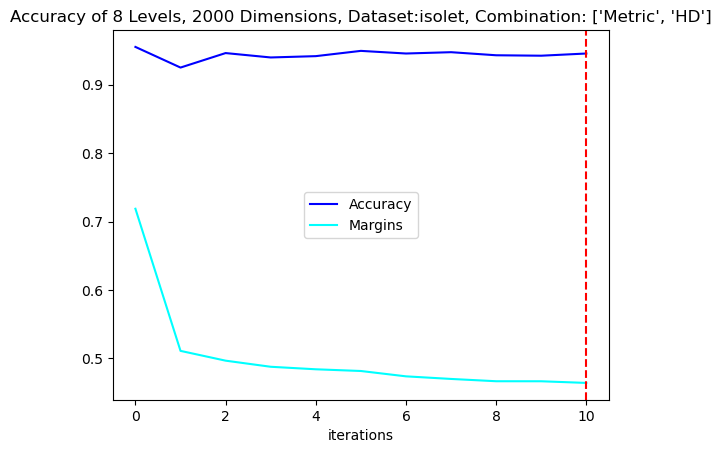

Final Acc: 0.9454779028892517  Final Margin: 0.4643038511276245


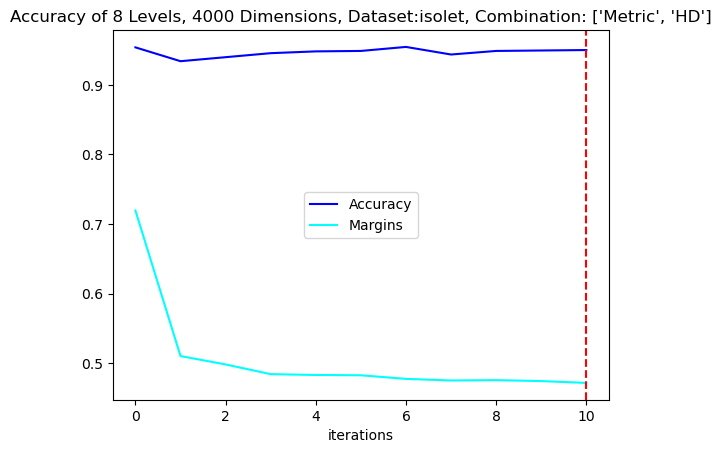

Final Acc: 0.9499679803848267  Final Margin: 0.4715771973133087


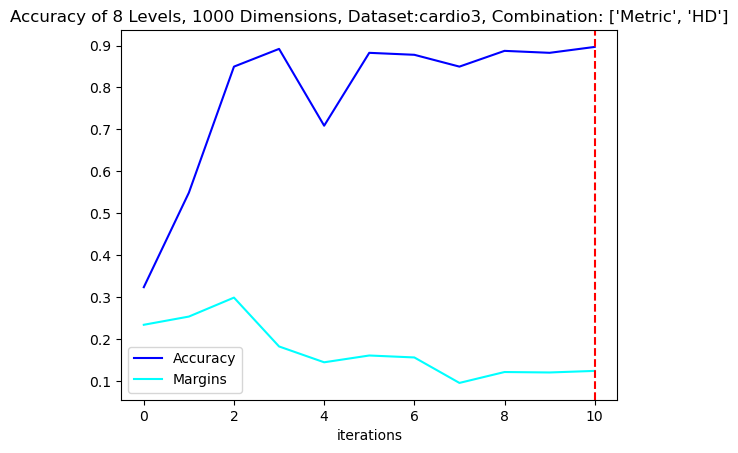

Final Acc: 0.8967136144638062  Final Margin: 0.1243809387087822


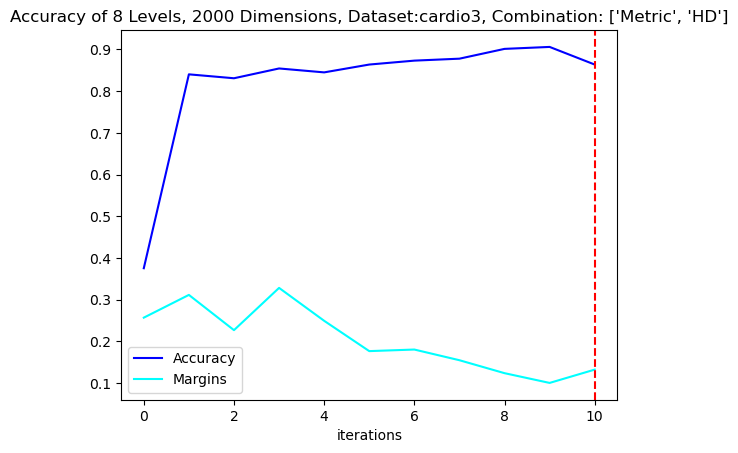

Final Acc: 0.8638497591018677  Final Margin: 0.1325286328792572


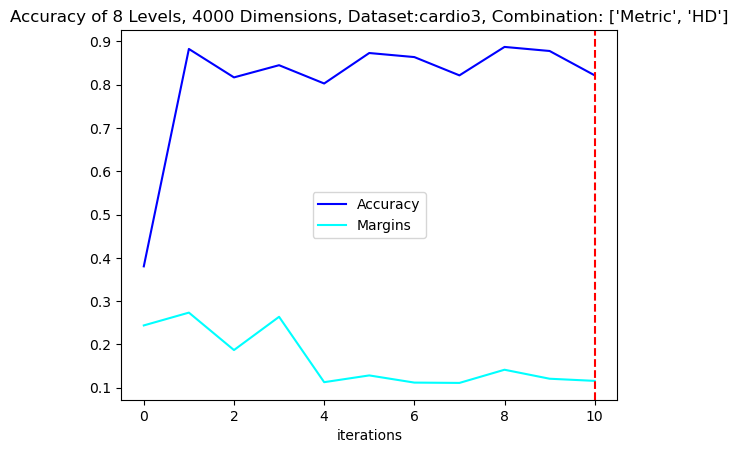

Final Acc: 0.8215962648391724  Final Margin: 0.11564832180738449


In [2]:
# training_methods = [ "HD", "Quant", "Metric"]
datasets = ["mnist", "pamap2", "ucihar","isolet","cardio3"]
levels = [8]
# dimensions = [100, 500, 5000, 10000]
dimensions = [1000, 2000, 4000]

results = {}
for dataset in datasets:
    nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader\
        = dataset_utils.load_dataset(dataset, 256, "cuda")
    results[dataset] = {}
    dataset_info = (nFeatures, nClasses, x_train, y_train, x_test, y_test, train_loader, test_loader)
    for dimension in dimensions:
        for level in levels:
            combination = ["Metric", "HD"]
            accuracies, margins = test_combination(dataset_info, dimension, level, combinations=combination)
            final_acc = accuracies[len(accuracies)-1]
            final_marg = margins[len(margins) - 1]
            print("Final Acc:", final_acc, " Final Margin:", final_marg)
            results[dataset][("Metric", "HD", level, dimension)] = (final_acc, final_marg)

In [3]:
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_excel("8levels.xlsx", sheet_name="Sheet1")

                                                      mnist  \
Metric HD 8 1000  (0.9595999717712402, 0.10304759442806244)   
            2000   (0.960099995136261, 0.08516150712966919)   
            4000  (0.9656999707221985, 0.08140850812196732)   

                                                   pamap2  \
Metric HD 8 1000  (0.95550537109375, 0.19138532876968384)   
            2000    (0.9705810546875, 0.2307491898536682)   
            4000     (0.90185546875, 0.20246148109436035)   

                                                     ucihar  \
Metric HD 8 1000    (0.9723294973373413, 0.439944863319397)   
            2000   (0.9742599725723267, 0.4012193977832794)   
            4000  (0.9761905074119568, 0.41091278195381165)   

                                                     isolet  \
Metric HD 8 1000  (0.9422706961631775, 0.46978363394737244)   
            2000   (0.9454779028892517, 0.4643038511276245)   
            4000   (0.9499679803848267, 0.4715771973133087) 